In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import talib

Populating the interactive namespace from numpy and matplotlib


In [2]:
PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"

df_emr = pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=',')
df_jbl = pd.read_csv(PATH_TO_DATA + "JBL.csv", sep=',')
df_met = pd.read_csv(PATH_TO_DATA + "MET.csv", sep=',')
df_see = pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=',')
df_intc = pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=',')
df_nvda = pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=',')

In [3]:
def crop(df, start='2016-03-01 10:00:00', end='2016-09-01 10:00:00'):
    df = df[df[df.dt == start].index[0]:df[df.dt == end].index[0]]
    df.index = pd.RangeIndex(df.shape[0])
    return df

In [4]:
df_emr = crop(df_emr)
df_jbl = crop(df_jbl)
df_met = crop(df_met)
df_see = crop(df_see)
df_intc = crop(df_intc)
df_nvda = crop(df_nvda)

<Figure size 1152x576 with 0 Axes>

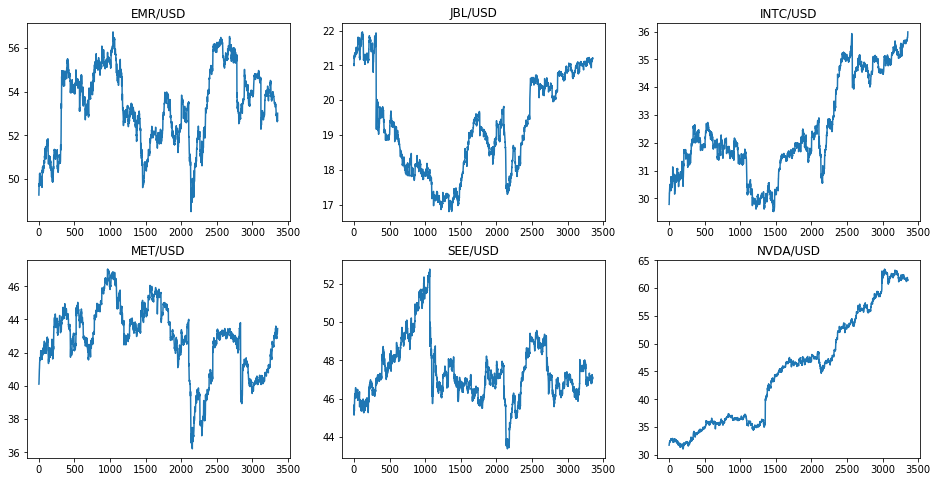

In [5]:
plt.figure(figsize(16,8))
fig, axs = plt.subplots(2, 3)

axs[0,0].plot(range(df_emr.shape[0]), df_emr['open'].values)
axs[0,1].plot(range(df_jbl.shape[0]), df_jbl['open'].values)
axs[1,0].plot(range(df_met.shape[0]), df_met['open'].values)
axs[1,1].plot(range(df_see.shape[0]), df_see['open'].values)
axs[0,2].plot(range(df_intc.shape[0]), df_intc['open'].values)
axs[1,2].plot(range(df_nvda.shape[0]), df_nvda['open'].values)

axs[0,0].title.set_text('EMR/USD')
axs[0,1].title.set_text('JBL/USD')
axs[1,0].title.set_text('MET/USD')
axs[1,1].title.set_text('SEE/USD')
axs[0,2].title.set_text('INTC/USD')
axs[1,2].title.set_text('NVDA/USD')

plt.show()

In [6]:
class IndicatorMarks():
    
    def __init__(self):
        pass
        
    def macd_marks(self, MACD):
        periods = len(MACD)
        temp = ['hold'] * periods
        for i in range(1, periods):
            if (MACD[i] > 0 and MACD[i-1] < 0):
                temp[i] = 'buy'
            elif (MACD[i] < 0 and MACD[i-1] > 0):
                temp[i] = 'sell'
        return temp
    
    def rsi_marks(self, rsi, buy_threshold=30, sell_threshold=70):
        periods = len(rsi)
        temp = ['hold'] * periods
        for i in range(1, periods):
            if (rsi[i] < buy_threshold):
                temp[i] = 'buy'
            elif (rsi[i] > sell_threshold):
                temp[i] = 'sell'
        return temp

In [7]:
class SingleInstrumentBacktest:
    
    df = None #dataframe
    price = None #open or close
    periods = None #number of periods
    balance = None #balance on current period of time
    fee = None #taker/maker fee
    stoploss = None
    takeprofit = None
    hold = 0 #current balance of an instrument
    i = 0 #current period index
    balance_on_buy = None #balance when bought to know current loss/profit
    wait = 0 #no action for "10" (e.g.) periods after stoploss/takeprofit
    
    
    def __init__(self, df, initial_balance=100, fee=0.1, stoploss=100, takeprofit=100):
        self.df = df.copy()
        self.price = self.df['open'].values
        self.periods = df.shape[0]
        self.df.index = pd.RangeIndex(self.periods) #refresh index
        self.balance = np.zeros(self.periods)
        self.balance[0] = initial_balance
        self.fee = fee
        self.stoploss = stoploss
        self.takeprofit = takeprofit
        self.add_indicator_marks()
        
        
    def add_indicator_marks(self):
        im = IndicatorMarks()
        self.df['macd'] = talib.EMA(self.price, timeperiod=13) - talib.EMA(self.price, timeperiod=26)
        self.df['macd_mark'] = im.macd_marks(self.df['macd'].values)
        self.df['rsi_14'] = talib.RSI(self.price, timeperiod=14)
        self.df['rsi_14_mark'] = im.rsi_marks(self.df['rsi_14'].values, 30, 70)
    
    
    def buy_condition(self):
        if (self.df['rsi_14_mark'][self.i] == 'buy' and self.wait == 0):
        #if (self.df['custom_signal'][self.i] == 'buy' and self.wait == 0):
            return True
        if (self.wait > 0):
            self.wait -= 1
        return False
    
    
    def sell_condition(self):
        if (self.df['rsi_14_mark'][self.i] == 'sell'):
        #if (self.df['custom_signal'][self.i] == 'sell'):
            return True
        #stoploss/takeprofit
        current_trade_loss = 1.0 - self.balance[self.i] / self.balance_on_buy
        if (current_trade_loss >= self.stoploss or -1.0 * current_trade_loss >= self.takeprofit):
            self.wait = 8
            return True
        return False
    
    
    def step(self):
        if self.hold == 0:
            if (self.buy_condition() == True):
                self.hold = self.balance[self.i-1] / self.price[self.i] * (1.0 - self.fee/100.0)
                self.balance_on_buy = self.balance[self.i-1]
            self.balance[self.i] = self.balance[self.i-1]
        else:
            self.balance[self.i] = self.hold * self.price[self.i] * (1.0 - self.fee/100.0)
            if (self.sell_condition() == True):
                self.hold = 0
        
        
    def full_backtest(self, print_metrics=True, show_balance=True):
        for _ in range(1, self.periods):
            self.i += 1
            self.step()
        if print_metrics == True:
            print(self.get_metrics())
        if show_balance == True:
            self.show_balance()
        return self.balance
    
    
    def show_balance(self):
        plt.plot(range(self.periods), self.balance)
        
        
    def get_metrics(self, digits=3):
        risk_free_return = 0
        self.df['return'] = self.balance / self.balance[0]
        max_drawdown = 1.0 - min(self.df['return'].values)
        self.df['return'] = self.df['return'].pct_change(1)
        sharpe = (self.df['return'].mean() - risk_free_return) / self.df['return'].std()
        sharpe *= self.periods ** 0.5 #annualize
        #sharpe = np.mean(ret) / np.std(ret)
        return {"profit factor" : round(self.balance[self.periods-1]/self.balance[0], digits), 
                "sharpe ratio" : round(sharpe, digits),
                "max drawdown" : str(round(max_drawdown * 100, digits-2)) + "%"}

In [8]:
plt.figure(figsize(8,3))

<Figure size 576x216 with 0 Axes>

<Figure size 576x216 with 0 Axes>

## Tests without stoploss/takeprofit

{'profit factor': 1.085, 'sharpe ratio': 0.818, 'max drawdown': '2.1%'}


array([100.        , 100.        , 100.        , ..., 107.85260343,
       107.82189078, 108.53851937])

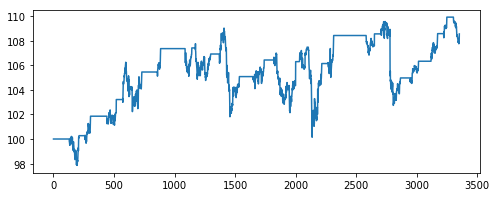

In [9]:
SingleInstrumentBacktest(df_emr, stoploss=1000, takeprofit=1000).full_backtest()

{'profit factor': 0.955, 'sharpe ratio': -0.238, 'max drawdown': '12.2%'}


array([100.        , 100.        , 100.        , ...,  95.49629656,
        95.58638741,  95.45125114])

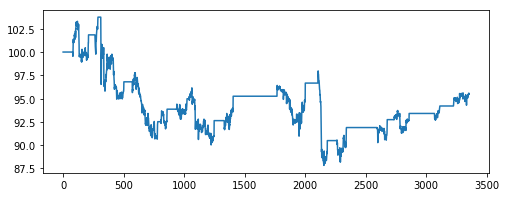

In [10]:
SingleInstrumentBacktest(df_jbl, stoploss=1000, takeprofit=1000).full_backtest()

{'profit factor': 0.899, 'sharpe ratio': -0.693, 'max drawdown': '16.1%'}


array([100.        , 100.        , 100.        , ...,  89.88756544,
        89.88756544,  89.88756544])

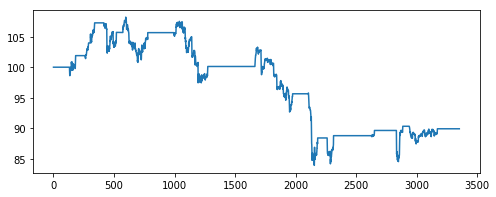

In [11]:
SingleInstrumentBacktest(df_met, stoploss=1000, takeprofit=1000).full_backtest()

{'profit factor': 1.092, 'sharpe ratio': 0.814, 'max drawdown': '0.9%'}


array([100.        , 100.        , 100.        , ..., 109.45662282,
       109.38697916, 109.24769184])

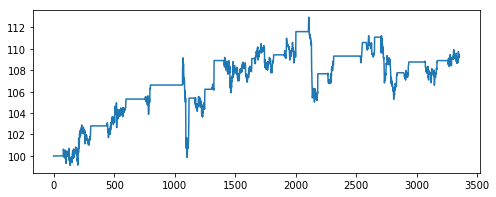

In [12]:
SingleInstrumentBacktest(df_see, stoploss=1000, takeprofit=1000).full_backtest()

{'profit factor': 1.131, 'sharpe ratio': 1.417, 'max drawdown': '0.0%'}


array([100.        , 100.        , 100.        , ..., 113.11193897,
       113.11193897, 113.11193897])

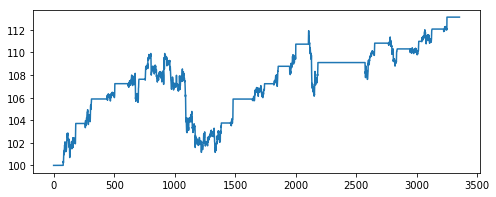

In [13]:
SingleInstrumentBacktest(df_intc, stoploss=1000, takeprofit=1000).full_backtest()

{'profit factor': 1.444, 'sharpe ratio': 2.602, 'max drawdown': '0.1%'}


array([100.        , 100.        , 100.        , ..., 144.67383078,
       144.67383078, 144.43855052])

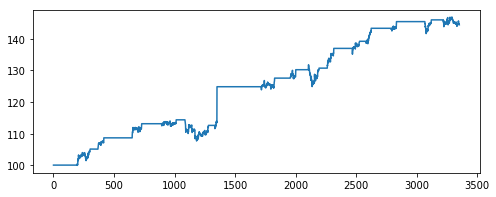

In [14]:
SingleInstrumentBacktest(df_nvda, stoploss=1000, takeprofit=1000).full_backtest()

## Tests with stoploss

In [15]:
#almost flat
SingleInstrumentBacktest(df_emr, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_emr, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #worse
SingleInstrumentBacktest(df_emr, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #worse

{'profit factor': 1.085, 'sharpe ratio': 0.818, 'max drawdown': '2.1%'}
{'profit factor': 1.045, 'sharpe ratio': 0.512, 'max drawdown': '2.1%'}
{'profit factor': 0.998, 'sharpe ratio': 0.028, 'max drawdown': '5.5%'}


array([100.        , 100.        , 100.        , ...,  99.20873229,
        99.18048111,  99.83967535])

In [16]:
#almost flat
SingleInstrumentBacktest(df_jbl, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_jbl, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #better
SingleInstrumentBacktest(df_jbl, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #better

{'profit factor': 0.955, 'sharpe ratio': -0.238, 'max drawdown': '12.2%'}
{'profit factor': 1.006, 'sharpe ratio': 0.113, 'max drawdown': '10.2%'}
{'profit factor': 1.01, 'sharpe ratio': 0.139, 'max drawdown': '7.0%'}


array([100.        , 100.        , 100.        , ..., 101.00211007,
       101.09739508, 100.95446756])

In [17]:
#down-trend
SingleInstrumentBacktest(df_met, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_met, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #worse
SingleInstrumentBacktest(df_met, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #better

{'profit factor': 0.899, 'sharpe ratio': -0.693, 'max drawdown': '16.1%'}
{'profit factor': 0.886, 'sharpe ratio': -0.902, 'max drawdown': '16.4%'}
{'profit factor': 1.003, 'sharpe ratio': 0.087, 'max drawdown': '6.1%'}


array([100.        , 100.        , 100.        , ..., 100.33713874,
       100.33713874, 100.33713874])

In [18]:
#up-trend with drawdowns
SingleInstrumentBacktest(df_see, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_see, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #better
SingleInstrumentBacktest(df_see, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #better

{'profit factor': 1.092, 'sharpe ratio': 0.814, 'max drawdown': '0.9%'}
{'profit factor': 1.119, 'sharpe ratio': 1.03, 'max drawdown': '0.9%'}
{'profit factor': 1.111, 'sharpe ratio': 1.018, 'max drawdown': '0.9%'}


array([100.        , 100.        , 100.        , ..., 111.34173548,
       111.27089238, 111.12920619])

In [19]:
#up-trend with drawdowns
SingleInstrumentBacktest(df_intc, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_intc, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #better
SingleInstrumentBacktest(df_intc, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #better

{'profit factor': 1.131, 'sharpe ratio': 1.417, 'max drawdown': '0.0%'}
{'profit factor': 1.14, 'sharpe ratio': 1.517, 'max drawdown': '0.0%'}
{'profit factor': 1.165, 'sharpe ratio': 1.765, 'max drawdown': '0.0%'}


array([100.        , 100.        , 100.        , ..., 116.47488795,
       116.47488795, 116.47488795])

In [20]:
#strong up-trend
SingleInstrumentBacktest(df_nvda, stoploss=1000, takeprofit=1000).full_backtest(show_balance=False) #no stoploss
SingleInstrumentBacktest(df_nvda, stoploss=0.03, takeprofit=1000).full_backtest(show_balance=False) #worse
SingleInstrumentBacktest(df_nvda, stoploss=0.02, takeprofit=1000).full_backtest(show_balance=False) #same

{'profit factor': 1.444, 'sharpe ratio': 2.602, 'max drawdown': '0.1%'}
{'profit factor': 1.322, 'sharpe ratio': 2.082, 'max drawdown': '0.1%'}
{'profit factor': 1.42, 'sharpe ratio': 2.527, 'max drawdown': '0.1%'}


array([100.        , 100.        , 100.        , ..., 142.2351051 ,
       142.2351051 , 142.00379089])

## Diversified Portfolio

In [21]:
def crop(df, start='2016-03-01 10:00:00', end='2016-09-01 10:00:00'):
    df = df[df[df.dt == start].index[0]:df[df.dt == end].index[0]]
    df.index = pd.RangeIndex(df.shape[0])
    return df

PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"
df_emr = crop(pd.read_csv(PATH_TO_DATA + "EMR.csv", sep=','))
df_jbl = crop(pd.read_csv(PATH_TO_DATA + "JBL.csv", sep=','))
df_met = crop(pd.read_csv(PATH_TO_DATA + "MET.csv", sep=','))
df_see = crop(pd.read_csv(PATH_TO_DATA + "SEE.csv", sep=','))

PATH_TO_DATA += "semiconductors/"
df_mu = crop(pd.read_csv(PATH_TO_DATA + "MU.csv", sep=','))
df_amat = crop(pd.read_csv(PATH_TO_DATA + "AMAT.csv", sep=','))
df_amd = crop(pd.read_csv(PATH_TO_DATA + "AMD.csv", sep=','))
df_intc = crop(pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=','))
df_klac = crop(pd.read_csv(PATH_TO_DATA + "KLAC.csv", sep=','))
df_lrcx = crop(pd.read_csv(PATH_TO_DATA + "LRCX.csv", sep=','))
df_mchp = crop(pd.read_csv(PATH_TO_DATA + "MCHP.csv", sep=','))
df_nvda = crop(pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=','))
df_ter = crop(pd.read_csv(PATH_TO_DATA + "TER.csv", sep=','))

dfs = [df_emr, df_jbl, df_met, df_see, df_mu, 
       df_amat, df_amd, df_intc, df_klac, 
       df_lrcx, df_mchp, df_nvda, df_ter]

In [22]:
def trade_everything(dfs, stoploss=1000, takeprofit=1000):
    periods = dfs[0]['open'].shape[0]
    balance = np.zeros(periods)
    avg_profit_factor = 0
    avg_max_drawdown = 0
    for df in dfs:
        sib = SingleInstrumentBacktest(df, stoploss=stoploss, takeprofit=takeprofit)
        balance += sib.full_backtest(print_metrics=False, show_balance=False)[0]
        metrics = sib.get_metrics()
        avg_profit_factor += metrics['profit factor']
    balance /= len(dfs)
    avg_profit_factor /= len(dfs)
    print(round(avg_profit_factor, 4))

In [23]:
#6 months
trade_everything(dfs) #no stoploss/takeprofit
trade_everything(dfs, stoploss=0.03) #no takeprofit
trade_everything(dfs, stoploss=0.05) #no takeprofit
trade_everything(dfs, stoploss=0.03, takeprofit=0.08)
trade_everything(dfs, stoploss=0.05, takeprofit=0.08)

1.1568
1.124
1.1054
1.1229
1.1043
